In [1]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
# from keras.layers.pooling import AveragePooling2D
# from keras.layers.core import Dropout
# from keras.layers.core import Flatten
# from keras.layers.core import Dense
import tensorflow
import keras
from keras.layers import Dense,AveragePooling2D,Dropout,Flatten,Dense
# from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense
from sklearn.preprocessing import LabelBinarizer
from keras.layers import Input
from keras.optimizers import Adam
from sklearn.metrics import classification_report
from keras.applications import ResNet50
from keras.applications import VGG16
from keras.applications import VGG19
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pickle
from keras.models import Model

ImportError: initialization failed

In [3]:
import os
dataset_path = "../Dataset/"

# List of folders within the dataset
folders = ["Leaf rust", "Fusarium Head Blight", "Healthy Wheat","Crown and Root Rot"]

# Initialize an empty list to store image paths
image_paths = []

# Iterate through each folder
for folder in folders:
    # Create the full path to the current folder
    folder_path = os.path.join(dataset_path, folder)
    
    # Check if the folder exists
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        # Get a list of all files in the folder
        files = os.listdir(folder_path)
        
        # Create the full paths to the image files and add them to the image_paths list
        image_paths.extend([os.path.join(folder_path, file) for file in files])

# Now, image_paths contains the full file paths of all images in the specified folders
print(image_paths)

label = "lb.pickle"

['../Dataset/Leaf rust\\00011.jpg', '../Dataset/Leaf rust\\00021.jfif', '../Dataset/Leaf rust\\00031.png', '../Dataset/Leaf rust\\00041.jpg', '../Dataset/Leaf rust\\00051.JPG', '../Dataset/Leaf rust\\00061.jpg', '../Dataset/Leaf rust\\00071.jpg', '../Dataset/Leaf rust\\00081.jfif', '../Dataset/Leaf rust\\00091.jpg', '../Dataset/Leaf rust\\00111.jpg', '../Dataset/Leaf rust\\00121.jpg', '../Dataset/Leaf rust\\00131.jpg', '../Dataset/Leaf rust\\00141.jpg', '../Dataset/Leaf rust\\00151.JPG', '../Dataset/Leaf rust\\00161.jfif', '../Dataset/Leaf rust\\00171.JPG', '../Dataset/Leaf rust\\00181.JPG', '../Dataset/Leaf rust\\00191.jpg', '../Dataset/Leaf rust\\00201.jfif', '../Dataset/Leaf rust\\00211.jfif', '../Dataset/Leaf rust\\00221.jpg', '../Dataset/Leaf rust\\00231.jfif', '../Dataset/Leaf rust\\00241.jfif', '../Dataset/Leaf rust\\00251.JPG', '../Dataset/Leaf rust\\00261.jpg', '../Dataset/Leaf rust\\00271.jpg', '../Dataset/Leaf rust\\00281.jfif', '../Dataset/Leaf rust\\00291.jpg', '../Dataset

In [6]:
LABELS = set(["Fusarium Head Blight", "Healthy Wheat", "Leaf Rust", "Crown and Root Rot"])
# imagePaths = list(paths.list_images(dataset))
# print(imagePaths)
data = []
labels = []
for imagePath in image_paths:
    # print(imagePath)
    label = imagePath.split(os.path.sep)[-2].split("/")[2]
    # print(label)
    if label not in LABELS:
        continue
    # print(label)
    image = cv2.imread(imagePath)
    if image is None or image.size == 0:
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # cv2.imshow(image,mat=image)
    data.append(image)
    labels.append(label)

data = np.array(data)
labels = np.array(labels)
print(lb.classes_)

['Crown and Root Rot' 'Fusarium Head Blight' 'Healthy Wheat']


In [7]:
data = np.array(data, dtype=np.float32)
labels = np.array(labels)
data=data/255.0
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
                                                  test_size=0.25, stratify=labels, random_state=42)

trainAug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")
print(lb.classes_)

['Crown and Root Rot' 'Fusarium Head Blight' 'Healthy Wheat']


In [5]:
valAug = ImageDataGenerator()

mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean

valAug.mean = mean

headmodel = VGG19(weights="imagenet", include_top=False,
                  input_tensor=Input(shape=(224, 224, 3)))

In [6]:
from keras.callbacks import ReduceLROnPlateau, Callback
from keras.layers import BatchNormalization
model = headmodel.output
model = AveragePooling2D(pool_size=(5, 5))(model)
model = Flatten(name="flatten")(model)
model = Dense(512, activation="relu")(model)
model=BatchNormalization()(model)
model = Dropout(0.4)(model)
model = Dense(len(lb.classes_), activation="softmax")(model)

moodel = Model(inputs=headmodel.input, outputs=model)

for layer in headmodel.layers[:-4]:
    layer.trainable = False

opt = Adam(lr=1e-4)
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpointer = [
    
    ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.8,
    patience=7,
    min_lr=1e-7,
    verbose=1,
),
    tensorflow.keras.callbacks.ModelCheckpoint(
        filepath="final_model_weights.keras",
        monitor="val_accuracy",
        verbose=1,
        save_best_only=True,
        mode="max"
)
]
moodel.compile(loss="categorical_crossentropy", optimizer=opt,
               metrics=["accuracy"])

Epoch 1/50



39/39 [==============================] - ETA: 0s - loss: 0.8065 - accuracy: 0.6976 
Epoch 1: val_accuracy improved from -inf to 0.29808, saving model to final_model_weights.keras
39/39 [==============================] - 536s 14s/step - loss: 0.8065 - accuracy: 0.6976 - val_loss: 15.6828 - val_accuracy: 0.2981 - lr: 0.0010
Epoch 2/50
39/39 [==============================] - ETA: 0s - loss: 0.5981 - accuracy: 0.7686 
Epoch 2: val_accuracy improved from 0.29808 to 0.61779, saving model to final_model_weights.keras
39/39 [==============================] - 494s 13s/step - loss: 0.5981 - accuracy: 0.7686 - val_loss: 1.6706 - val_accuracy: 0.6178 - lr: 0.0010
Epoch 3/50
39/39 [==============================] - ETA: 0s - loss: 0.5327 - accuracy: 0.8049 
Epoch 3: val_accuracy improved from 0.61779 to 0.69471, saving model to final_model_weights.keras
39/39 [==============================] - 560s 14s/step - loss: 0.5327 - accuracy: 0.8049 - val_loss: 1.2080 - val_accuracy: 0.6947 - lr: 0.0010
Ep

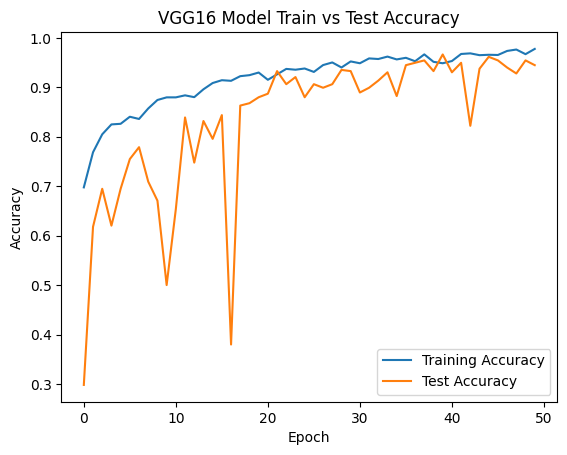

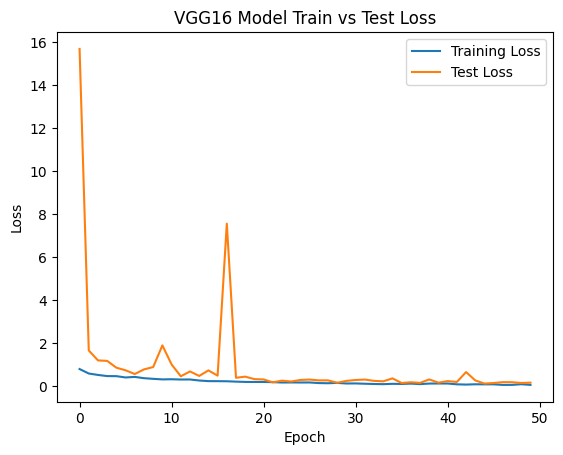

c:\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully.


<Figure size 640x480 with 0 Axes>

In [7]:
H = moodel.fit(
    trainAug.flow(trainX, trainY, batch_size=64),
    steps_per_epoch=len(trainX) // 64,
    validation_data=valAug.flow(testX, testY),
    validation_steps=len(testX) // 64,
    epochs=50,
    callbacks=[checkpointer,early_stopping]
    )

predictions = moodel.predict(testX, batch_size=64)
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1), target_names=lb.classes_))

N = 50
plt.plot(np.arange(0, N), H.history['accuracy'], label="Training Accuracy")
plt.plot(np.arange(0, N), H.history['val_accuracy'], label="Test Accuracy")
plt.title('VGG16 Model Train vs Test Accuracy')
plt.ylabel('Accuracy')              
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()
plt.savefig("acc_plot.png")

plt.plot(H.history['loss'], label="Training Loss")
plt.plot(H.history['val_loss'], label="Test Loss")
plt.title('VGG16 Model Train vs Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()
plt.savefig("loss_plot.png")

# save the model to disk
try:
    # Save the entire model including weights, architecture, and optimizer state
    moodel.save("model1.h5")
    print("Model saved successfully.")
except Exception as e:
    print(f"Error saving the model: {e}")


f = open("label", "wb")
f.write(pickle.dumps(lb))
f.close() 



git init
git add README.md
git commit -m "first commit"
git branch -M main
git remote add origin https://github.com/bvijay042002/WheatLeaf-Disease-Detection.git
git push -u origin main











